#  The role of Bitcoin in a 3-asset portfolio

## Table of contents
1. Executive summary
2. Data description & cleaning
3. Initial exploratory analysis 
4. Comparison of asset class risk & returns
5. Bitcoin and inflation
6. Portfolio analysis: Finding the minimum volatility and maximum Sharpe ratio portfolios<br>
    6.1. Illustrative portfolio examples<br>
    6.2. Random sampling to approximate the efficient frontier<br>
    6.3. Portfolio optimization with PyPortfolioOpt<br>
    6.4. Illustration of optimal portfolios
7. Summary of main findings 
8. Portfolio recommendations & next steps
9. References

## 1. Executive summary
Bitcoin (BTC) - the most popular of cryptocurrencies - has developed from a niche project for IT-savvy people into a mainstream investment vehicle. The emergence of easy-to-access wallets and ETFs now allows a wide audience - from small retail speculators to large institutional investors - to invest into Bitcoin. As an investment firm we are facing the question **whether an allocation to Bitcoin could improve our fund's performance?**<br>

To help answer this question, this report will analyze Bitcoin's performance since 2014, alongside the two other major asset classes in our fund, US equities and gold. In doing so we will **answer several questions**:
- How does the performance of Bitcoin (i.e. risk and returns) compare to the S&P 500 and the price of gold?
- How does the inclusion of Bitcoin change a portfolio's characteristics and can it help improve a portfolio's performance?
- Could Bitcoin be used as a hedge against inflation?
- In the light of our fund's goal to minimize risk: What is the minimum volatility portfolio, consisting of these three asset classes? And for comparison: Which portfolio would maximize risk-adjusted returns?

The report starts with a brief description and cleaning of the data. We then do some initial exploratory analysis on returns and market behavior, before comparing risk and returns of the three asset classes in more detail. Next, we analyze the relationship of Bitcoin with inflation. Finally, section 6 analyzes the asset classes in a portfolio context, optimizing for minimum volatility as well as maximum risk-adjusted returns. We do so in several steps to make results more tangible and easier to understand. The report concludes with recommendations for the fund's allocation as well as for next steps.

**A note of caution**: This analysis is entirely backward-looking, relying on past performance data. That's valuable information to help answer the questions above. At the same time it shouldn't simply be extrapolated into the future. The observation period of the data (2014-2021) is relatively short, arguably not capturing a full business cycle. Inflation has been relatively low throughout most of this period. Meanwhile the period captures the initial stage of Bitcoin developing into a mainstream investment and attracting huge investor inflows. Behavior might differ significantly in the future. Thus before taking the final investment decision we recommend complementig these findings with further forward-looking analysis.

## 2. Data description & cleaning 

**Data used for the analysis:**

1) Bitcoin and S&P 500 daily data (in US dollars)
> - "date" - date from September 17, 2014 to November 17, 2021
> - "open" - the price / index level at the beginning of the trading day
> - "high" - the highest level reached that day
> - "low" - the lowest level reached that day
> - "close" - the price / level at the closing of the trading day
> - "volume" - how many Bitcoin / shares in the companies that make up the index were traded that day

2) Inflation and gold as monthly data
> - "date" - date from September, 2014 to November, 2021
> - "gold_usd" - price in usd of gold for that month
> - "cpi_us" - the inflation index for the US for that month (cpi = consumer price index)

**Remarks on the data:**<br>
The data consists of daily observations for the S&P 500 (1805 rows; no missing data) and Bitcoin (2619 rows; 4 missing data points) as well as monthly observations for gold and US inflation (87 rows; no missing data). The data covers a time period of roughly 7 years (from September 2014 to November 2021). 

A check of the data source shows that CPI refers to prior month's inflation index (e.g. 2021-11-01 is October's data point). The gold price is given for the 1st day of each month. We will interpret it as the price of the last day of the prior month to better match it with inflation data. We'll use the S&P 500 as a proxy for US equities and refer to both interchangeably.

**Getting started:**<br>
First, we import necessary libraries and load the data. We drop the 4 missing data points in the Bitcoin dataframe. We then merge the (monthly resampled) Bitcoin and S&P 500 dataframes with the gold and inflation data on the appropriate date. As there are only monthly observations of the gold price and inflation, we will conduct most of the analysis on monthly data, which anyway is an appropriate frequency for asset allocation decisions.

In [1]:
#Import necessary libraries (some will be added later, where they are needed)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import numpy as np
from datetime import datetime
from datetime import timedelta
plt.rcParams.update({'font.size':12})

In [4]:
#Import the data
bitcoin = pd.read_csv('M:/project/Bitcoin/data/bitcoin-usd.csv', parse_dates=['date'])
sp500 = pd.read_csv('M:/project/Bitcoin/data/sp500.csv', parse_dates=['date'])
monthly_data = pd.read_csv('M:/project/Bitcoin/data/monthly_data.csv', parse_dates=['date'])

In [5]:
#Merge data and convert to monthly frequency
merged1 = sp500.merge(bitcoin, on = 'date', how = 'left', suffixes=['_sp500','_btc']).dropna()
merged1.set_index('date', inplace=True)
merged1_last = merged1.resample('M').last()

In [6]:
monthly_data['date'] = monthly_data['date'] - timedelta(days=1)
monthly_data.set_index('date', inplace=True)

merged2 = merged1_last.merge(monthly_data, left_index=True, right_index=True)
merged2.drop(['open_sp500','high_sp500','low_sp500','volume_sp500','open_btc','high_btc','low_btc','volume_btc'], axis=1, inplace=True)

In [7]:
#Define some chart formatting needed for most charts below
def chart_formatter(ax_numbers):
    for i in range(ax_numbers):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].tick_params(left=False)

In [15]:
merged2.index

DatetimeIndex(['2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
      

## 3. Initial exploratory analysis
To gain first insights into the behavior of the three asset classes, we first compare their performance since 2014 in figure 1. We also take a look at the development of daily trading volumes for equities and Bitcoin.

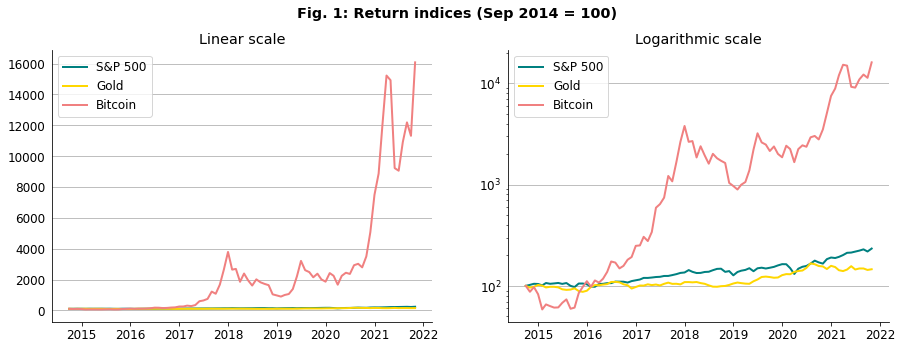

In [18]:
#Calculate standardized return indices and plot
merged2['close_sp500_std'] = merged2.close_sp500 / merged2.close_sp500[0] * 100
merged2['close_btc_std'] = merged2.close_btc / merged2.close_btc[0] * 100
merged2['close_gold_std'] = merged2.gold_usd / merged2.gold_usd[0] * 100

fig, ax = plt.subplots(1,2,figsize=(15,5))
plt.suptitle('Fig. 1: Return indices (Sep 2014 = 100)',fontweight='bold',y=1.0)

ax[0].plot(merged2.index, merged2.close_sp500_std, color='teal', lw=2)
ax[0].plot(merged2.index, merged2.close_gold_std, color='gold', lw=2)
ax[0].plot(merged2.index, merged2.close_btc_std, color='lightcoral', lw=2)
ax[0].set_title('Linear scale')
ax[0].legend(['S&P 500','Gold','Bitcoin'])
ax[0].grid(axis='y')

ax[1].plot(merged2.index, merged2.close_sp500_std, color='teal', lw=2)
ax[1].plot(merged2.index, merged2.close_gold_std, color='gold', lw=2)
ax[1].plot(merged2.index, merged2.close_btc_std, color='lightcoral', lw=2)
plt.yscale('log')
ax[1].set_title('Logarithmic scale')
ax[1].legend(['S&P 500','Gold','Bitcoin'])
ax[1].grid(axis='y')
chart_formatter(2)
plt.show()

In [461]:
#Calculate period performance & annualized performance
sp500_perf = (merged2.close_sp500[-1] / merged2.close_sp500[0]) - 1
sp500_perf_ann = (sp500_perf + 1) ** (1 / (len(merged2) / 12)) - 1

gold_perf = (merged2.gold_usd[-1] / merged2.gold_usd[0]) - 1
gold_perf_ann = (gold_perf + 1) ** (1 / (len(merged2) / 12)) - 1

btc_perf = (merged2.close_btc[-1] / merged2.close_btc[0]) - 1
btc_perf_ann = (btc_perf + 1) ** (1 / (len(merged2) / 12)) - 1

> **Finding 1**<br>
Figure 1 shows strong outperformance of Bitcoin over the observation period. From September 2014 until October 2021 Bitcoin (+103.2% p.a.) massively outperformed both gold (+5.4% p.a.) and the S&P 500 (12.5% p.a.). Over the entire period Bitcoin's value increased by a factor of roughly 160x, compared to 2.3x for the S&P 500 and 1.5x for gold.

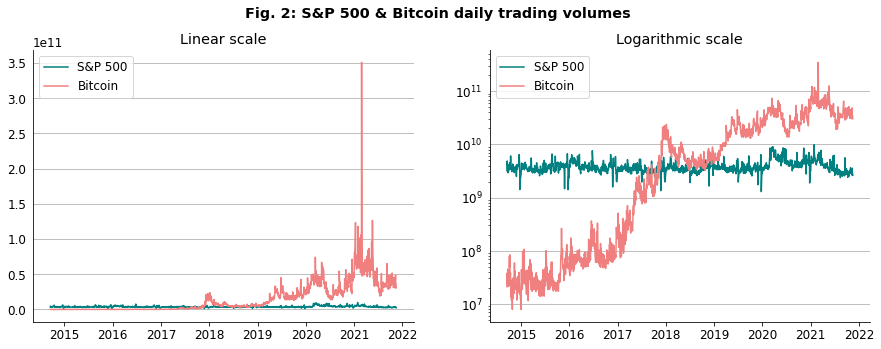

In [462]:
#Plot daily trading volumes
fig, ax = plt.subplots(1,2,figsize=(15,5))
plt.suptitle('Fig. 2: S&P 500 & Bitcoin daily trading volumes',fontweight='bold',y=1.0)

ax[0].plot(merged1.index, merged1.volume_sp500, label='S&P 500', color='teal')
ax[0].plot(merged1.index, merged1.volume_btc, label='Bitcoin', color='lightcoral')
ax[0].legend()
ax[0].grid(axis='y')
ax[0].set_title('Linear scale')

ax[1].plot(merged1.index, merged1.volume_sp500, label='S&P 500', color='teal')
ax[1].plot(merged1.index, merged1.volume_btc, label='Bitcoin', color='lightcoral')
plt.yscale('log')
ax[1].legend()
ax[1].grid(axis='y')
ax[1].set_title('Logarithmic scale')

chart_formatter(2)
plt.show()

> **Finding 2**<br> 
Figure 2 highlights the rising popularity of Bitcoin based on its trading volume. While trading volume of S&P 500 stocks has been relatively stable throughout the period, it has risen sharply for Bitcoin. Until late-2017 daily S&P 500 trading volumes exceeded Bitcoin's. Since then the trading volume in Bitcoin has been larger than S&P 500's, and by a wide margin lately (e.g. by a factor of 12.5x so far in 2021 on average: 50bn Bitcoins vs. 4bn S&P 500 shares). **Note of caution:** The Bitcoin trading volume looks unrealistically high; data should be verified and is not used for further analysis.

## 4. Comparison of asset class risk & returns
In this section we take a closer look at the historic performance and risk of US equities, Bitcoin and gold.

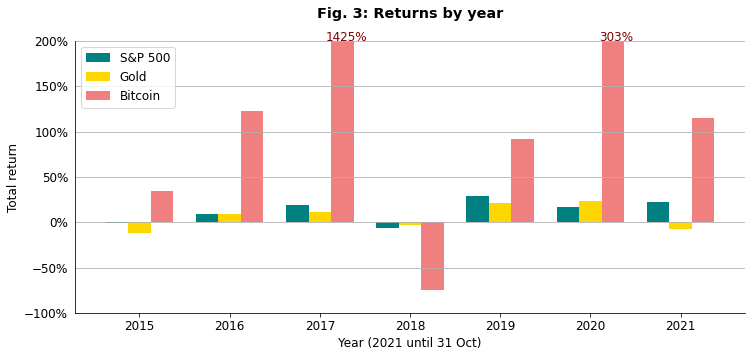

In [463]:
#Annual dataframe for performance comparison
annual = merged2.resample('Y').last()

annual['sp500_pct'] = annual.close_sp500.pct_change()
annual['btc_pct'] = annual.close_btc.pct_change()
annual['gold_pct'] = annual.gold_usd.pct_change()
annual.drop(annual.index[0], inplace=True)

fig, ax = plt.subplots(figsize=(12,5))
plt.title('Fig. 3: Returns by year', pad=23, fontweight='bold')

years = annual.index.year
x_axis = np.arange(len(years))

ax.bar(x_axis, annual.sp500_pct, width=0.25, label = 'S&P 500', color='teal')
ax.bar(x_axis + 0.25, annual.gold_pct, width=0.25, label = 'Gold', color='gold')
ax.bar(x_axis + 0.5, annual.btc_pct, width=0.25, label = 'Bitcoin', color='lightcoral')

plt.xticks(x_axis + 0.25, years)
plt.ylim([-1,2])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(axis='y')
ax.legend(loc='upper left')
ax.set_ylabel('Total return')
ax.set_xlabel('Year (2021 until 31 Oct)')
ax.annotate('1425%', (2.32, 2), color='maroon')
ax.annotate('303%', (5.35, 2), color='maroon')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(left=False)

plt.show()

> **Finding 3**<br> 
As can be seen in figure 3 Bitcoin outperformed in each single year except for 2018, and did so by a wide margin. Bitcoin's performance was particularly strong in 2017 (+1425%) and 2020 (+303%). We will next look at the distribution of monthly returns for each asset class to better understand their behavior.

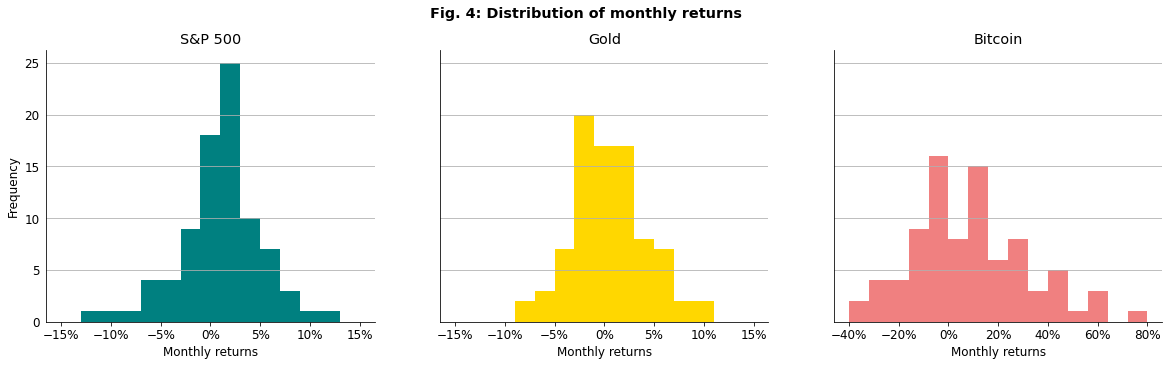

In [464]:
#Add monthly change columns and plot histograms
merged2['sp500_pct'] = merged2.close_sp500.pct_change()
merged2['btc_pct'] = merged2.close_btc.pct_change()
merged2['gold_pct'] = merged2.gold_usd.pct_change()

fig, ax = plt.subplots(1,3,figsize=(20,5),sharey=True)
plt.suptitle('Fig. 4: Distribution of monthly returns',fontweight='bold',y=1.0)

ax[0].hist(merged2.sp500_pct, bins=15, range=[-0.15,0.15], color='teal')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax[0].set_title('S&P 500')
ax[0].set_xlabel('Monthly returns')
ax[0].set_ylabel('Frequency')
ax[0].grid(axis='y')

ax[1].hist(merged2.gold_pct, bins=15, range=[-0.15,0.15], color='gold')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax[1].set_title('Gold')
ax[1].set_xlabel('Monthly returns')
ax[1].grid(axis='y')

ax[2].hist(merged2.btc_pct, bins=15, range=[-0.4,0.8], color='lightcoral')
ax[2].xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax[2].set_title('Bitcoin')
ax[2].set_xlabel('Monthly returns')
ax[2].grid(axis='y')

chart_formatter(3)
plt.show()

> **Finding 4**<br> 
Figure 4 shows that the range of monthly returns is much larger for Bitcoin than for US equities or gold. Over the observed time period, the distribution of monthly returns for US equities and gold is reasonably close to a normal distribution with a modal value around zero (slightly positive for S&P 500 and slightly negative for gold) and a slight negative skew for US stocks. In contrast, the distribution of Bitcoin returns is much flatter with considerably fatter tails (both positive and negative) and a positive skew. So in short, extreme outcomes are much more common for Bitcoin (also note the different x-axis scales) and returns tended to be positive more often than negative. Let's explore asset class risk further.

In [465]:
#Calculate standard deviation and Sharpe ratio
sp500_std_ann = merged2.sp500_pct.std() * (12 ** 0.5)
btc_std_ann = merged2.btc_pct.std() * (12 ** 0.5)
gold_std_ann = merged2.gold_pct.std() * (12 ** 0.5)

sp500_sharpe = sp500_perf_ann / sp500_std_ann
btc_sharpe = btc_perf_ann / btc_std_ann
gold_sharpe = gold_perf_ann / gold_std_ann

#Max drawdowns
merged2['sp500_dd'] = merged2.close_sp500 / merged2.close_sp500.expanding().max() - 1
merged2['btc_dd'] = merged2.close_btc / merged2.close_btc.expanding().max() - 1
merged2['gold_dd'] = merged2.gold_usd / merged2.gold_usd.expanding().max() - 1

sp500_maxDD = min(merged2.sp500_dd)
btc_maxDD = min(merged2.btc_dd)
gold_maxDD = min(merged2.gold_dd)

#For record: Max DD on daily data for SP500 and BTC
sp500_maxDD_daily = min(merged1.close_sp500 / merged1.close_sp500.expanding().max() - 1)
btc_maxDD_daily = min(merged1.close_btc / merged1.close_btc.expanding().max() - 1)

#Historical Var(95%) & CVar(5%)
sp500_Var = merged2.sp500_pct.nsmallest(5)[4]
btc_Var = merged2.btc_pct.nsmallest(5)[4]
gold_Var = merged2.gold_pct.nsmallest(5)[4]

sp500_CVar = merged2.sp500_pct.nsmallest(4).mean()
btc_CVar = merged2.btc_pct.nsmallest(4).mean()
gold_CVar = merged2.gold_pct.nsmallest(4).mean()

#Summary table
Stats = {'Annual return (in %)': [round(sp500_perf_ann*100,1), round(gold_perf_ann*100,1), round(btc_perf_ann*100,1)], 
        'Annual volatility (in %)': [round(sp500_std_ann*100,1), round(gold_std_ann*100,1), round(btc_std_ann*100,1)],
        'Sharpe ratio': [round(sp500_sharpe,1), round(gold_sharpe,1), round(btc_sharpe,1)],
        'Max. drawdown (mthly, in %)': [round(sp500_maxDD*100,1), round(gold_maxDD*100,1), round(btc_maxDD*100,1)],
        'Max. drawdown (daily, in %)': [round(sp500_maxDD_daily*100,1), 'n/a', round(btc_maxDD_daily*100,1)], 
        'VaR(95) (in %)': [round(sp500_Var*100,1), round(gold_Var*100,1), round(btc_Var*100,1)], 
        'CVaR(5) / Expected shortfall (in %)': [round(sp500_CVar*100,1), round(gold_CVar*100,1), round(btc_CVar*100,1)] }

Stats_df = pd.DataFrame(Stats).transpose()
Stats_df.columns = ['S&P 500', 'Gold', 'Bitcoin']

print('\033[1m' + 'Fig. 5: Asset class summary statistics (2014-2021)')
display(Stats_df)

Fig. 5: Asset class summary statistics (2014-2021)


,S&P 500,Gold,Bitcoin
Annual return (in %),12.6,5.4,103.2
Annual volatility (in %),14.4,12.6,82.5
Sharpe ratio,0.9,0.4,1.3
"Max. drawdown (mthly, in %)",-20.0,-16.1,-76.4
"Max. drawdown (daily, in %)",-33.9,n/a,-83.0
VaR(95) (in %),-6.6,-5.7,-29.3
CVaR(5) / Expected shortfall (in %),-9.3,-6.8,-34.0


> **Finding 5**<br>
Figure 5 confirms that the significantly higher average return of Bitcoin has come at the expense of significantly higher risks. Annualized volatility (based on monthly data) is a whopping 82.5% compared to 14.4% for US equities. The maximum drawdown realized over the period was -83% compared to -34% for the S&P 500 (based on daily data). Still, on risk-adjusted returns, as measured by the Sharpe ratio, Bitcoin's 1.3 compares favorably to both US stocks (0.9) and gold (0.4). Note that we are using a risk-free rate of zero throughout this report, sticking to the data provided.

> Acknowledging the shortcomings of volatility as a risk measure (e.g. it captures upside volatility as well, which might actually be desirable), we add the historic Value-at-Risk (VaR) for the 95% confidence interval: Bitcoin's VaR of -29.3% has been more than 4-times that of US equities. Finally, "expected shortfall" measures the mean loss below the VaR and gives another indication of Bitcoin's significant tail risk: -34% for Bitcoin vs. -9.3% for US equities. VaR and Conditional VaR have their own drawbacks, such as the implicit assumption of normal distribution and should be used carefully too. But in short, Bitcoin comes with significantly higher risk across all measures we looked at.

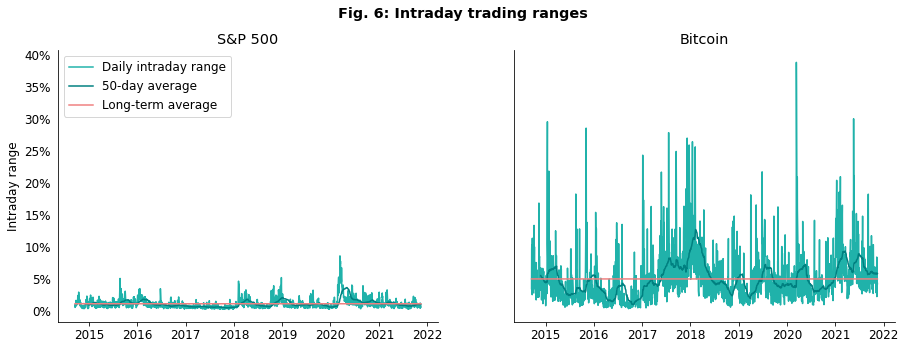

In [466]:
#Add daily intraday trading ranges and plot (SP 500 & BTC only)
merged1['range_sp500'] = (merged1.high_sp500 - merged1.low_sp500) / merged1.open_sp500
merged1['range_btc'] = (merged1.high_btc - merged1.low_btc) / merged1.open_btc

merged1['avg_range_sp500'] = merged1.range_sp500.mean()
merged1['avg_range_btc'] = merged1.range_btc.mean()

fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
plt.suptitle('Fig. 6: Intraday trading ranges',fontweight='bold',y=1.0)

ax[0].plot(merged1.index, merged1.range_sp500, color='lightseagreen', label='Daily intraday range')
ax[0].plot(merged1.index, merged1.range_sp500.rolling(50).mean(), color='teal', label='50-day average')
ax[0].plot(merged1.index, merged1.avg_range_sp500, color='lightcoral', label='Long-term average')
ax[0].set_title('S&P 500')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax[0].set_ylabel('Intraday range')
ax[0].legend(loc='upper left')

ax[1].plot(merged1.index, merged1.range_btc, color='lightseagreen')
ax[1].plot(merged1.index, merged1.range_btc.rolling(50).mean(), color='teal')
ax[1].plot(merged1.index, merged1.avg_range_btc, color='lightcoral')
ax[1].set_title('Bitcoin')

chart_formatter(2)
plt.show()

> **Finding 6**<br>
Another way to highlight Bitcoin's risk is to look at its intraday trading range compared to US equities (figure 6). The long-term average is 4.9% for Bitcoin vs. 1% for the S&P 500. More interesting are the spikes, which have reached 30-40% for Bitcoin on extreme days - a far cry from what has been observed for equities. Such large intraday swings can potentially cause problems for portfolio (risk) management.

## 5. Bitcoin and inflation
Before we turn to portfolio considerations, let's explore how these asset classes are correlated to one another and to inflation and whether Bitcoin has been a good hedge against inflation.

In [467]:
#Calculate correlation matrix on monthly changes
merged2['cpi_pct'] = merged2.cpi_us.pct_change()

corr_df = merged2[['sp500_pct', 'gold_pct', 'btc_pct', 'cpi_pct']].dropna()
corr_df.columns = ['S&P 500', 'Gold', 'Bitcoin', 'US CPI']

corr_mat = corr_df.corr().round(2)

In [468]:
#Import scipy for linear regressions
from scipy import stats

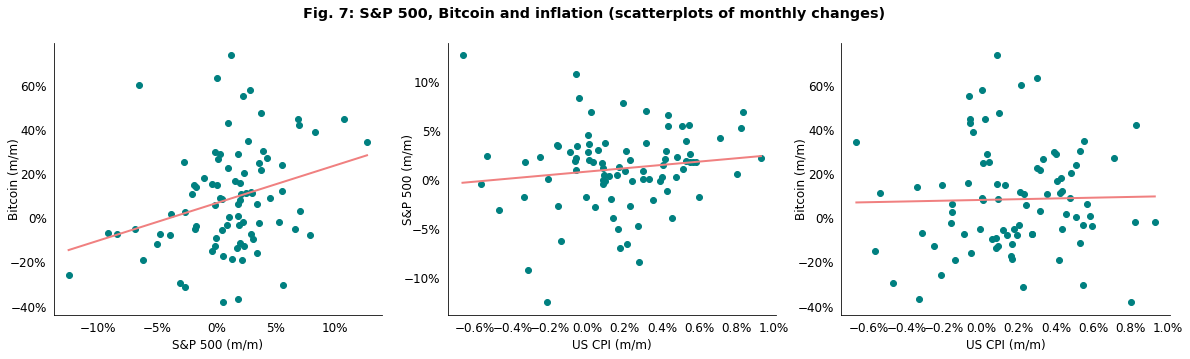


Fig. 8: Correlation coefficients


,S&P 500,Gold,Bitcoin,US CPI
S&P 500,1.00,-0.15,0.30,0.11
Gold,-0.15,1.00,-0.01,-0.08
Bitcoin,0.30,-0.01,1.00,0.04
US CPI,0.11,-0.08,0.04,1.00


In [469]:
#Scatterplots with linear regression lines
sp = corr_df['S&P 500']
btc = corr_df['Bitcoin']
cpi = corr_df['US CPI']

res1 = stats.linregress(sp, btc)
res2 = stats.linregress(cpi, sp)
res3 = stats.linregress(cpi, btc)

fig, ax = plt.subplots(1,3, figsize=(20,5))
fig.suptitle('Fig. 7: S&P 500, Bitcoin and inflation (scatterplots of monthly changes)',fontweight='bold')

ax[0].scatter(corr_df['S&P 500'], corr_df['Bitcoin'], color='teal')
ax[0].set_xlabel('S&P 500 (m/m)')
ax[0].set_ylabel('Bitcoin (m/m)',labelpad=-10)
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax[0].tick_params(bottom=False)

fx = np.array([sp.min(), sp.max()])
fy = res1.intercept + res1.slope * fx
ax[0].plot(fx,fy,color='lightcoral',lw=2)

ax[1].scatter(corr_df['US CPI'], corr_df['S&P 500'], color='teal')
ax[1].set_xlabel('US CPI (m/m)')
ax[1].set_ylabel('S&P 500 (m/m)',labelpad=-10)
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=1))
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax[1].tick_params(bottom=False)

fx = np.array([cpi.min(), cpi.max()])
fy = res2.intercept + res1.slope * fx
ax[1].plot(fx,fy,color='lightcoral',lw=2)

ax[2].scatter(corr_df['US CPI'], corr_df['Bitcoin'], color='teal')
ax[2].set_xlabel('US CPI (m/m)')
ax[2].set_ylabel('Bitcoin (m/m)',labelpad=-10)
ax[2].xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=1))
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax[2].tick_params(bottom=False)

fx = np.array([cpi.min(), cpi.max()])
fy = res3.intercept + res1.slope * fx
ax[2].plot(fx,fy,color='lightcoral',lw=2)

chart_formatter(3)
plt.show()

print()
print('\033[1m' + 'Fig. 8: Correlation coefficients')
display(corr_mat)

> **Finding 7**<br>
The scatterplot of monthly changes (right chart in figure 7) as well as the correlation coefficient of close to zero (figure 8) suggest that there has been no consistent relationship between changes in the price of Bitcoin and inflation since 2014. In itself Bitcoin does not offer good hedging properties against inflation, as it has been largely uncorrelated to changes in the general price level. It seems neither positively nor negatively affected by inflation. 

> It's also worth noting the positive correlation between the S&P 500 and Bitcoin. A correlation coefficient of 0.3 suggests that Bitcoin tends to move in the same direction as equities, thus offering only limited diversification benefits in a portfolio with equities (unlike gold, which is somewhat negatively correlated to stock performance). 

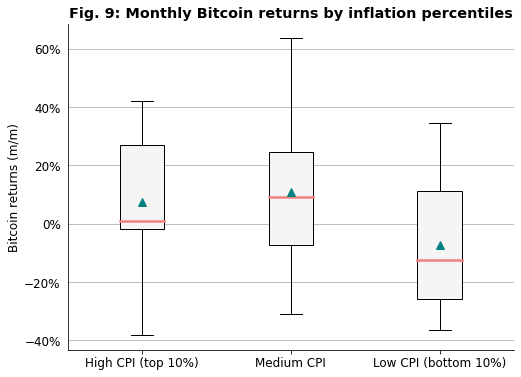

In [470]:
#Find BTC returns in different inflation percentiles and show in boxplot
btc_90perc = corr_df['Bitcoin'][corr_df['US CPI'] >= np.percentile(corr_df['US CPI'],90)]
btc_between = corr_df['Bitcoin'][corr_df['US CPI'] < np.percentile(corr_df['US CPI'],90)][corr_df['US CPI'] > np.percentile(corr_df['US CPI'],10)]
btc_10perc = corr_df['Bitcoin'][corr_df['US CPI'] <= np.percentile(corr_df['US CPI'],10)]

perc_data =  [btc_90perc, btc_between, btc_10perc]

fig, ax = plt.subplots(figsize=(8,6))
plt.title('Fig. 9: Monthly Bitcoin returns by inflation percentiles',fontweight='bold')

ax.boxplot(perc_data,labels=['High CPI (top 10%)','Medium CPI','Low CPI (bottom 10%)'],showfliers=False,showmeans=True,patch_artist=True,
           boxprops=dict(facecolor='whitesmoke'),medianprops=dict(color='lightcoral',linewidth=2.5),meanprops=dict(markerfacecolor='teal',markeredgecolor='teal',markersize=8))

ax.set_ylabel('Bitcoin returns (m/m)')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(left=False)
ax.grid(axis='y')

plt.show()

> **Finding 8**<br>
For figure 9 we split the monthly inflation data into its 90th percentile (top 10%), 10th percentile (bottom 10%) and all observations in between (medium) and analyze the behavior of Bitcoin in each of these "buckets" in a boxplot. This confirms our prior finding: Bitcoin returns, when inflation is particularly high (i.e. in its 90th percentile) have not been significantly different from Bitcoin returns, when inflation is "normal/medium". In fact, both mean (triangle) and median (line) returns have actually been somewhat lower in high inflation months. Also, the range of outcomes under high inflation is wide and the most negative outcome actually occurred under high inflation. So, Bitcoin does not offer reliable protection against high inflation. Interestingly, Bitcoin returns have been lower (on mean, median and interquartile range), when inflation was particularly subdued (i.e. in the 10th percentile).
<br>

> Note: The low/high percentiles contain just 9 observations each! Results are pretty sensitive to the choice of percentile cutoff, but they don't "improve" using other cutoff points.
<br>

## 6. Portfolio analysis: Finding the minimum volatility and maximum Sharpe ratio portfolios
So far we learned that Bitcoin’s stellar performance since 2014 (+103% p.a.) came at the expense of extraordinary risks (e.g. volatility, drawdowns, VaR). Still, its Sharpe ratio compares favourably to equities and gold. While mildly positively correlated to the S&P 500, Bitcoin has shown no consistent relationship to inflation. While Bitcoin should not be thought of as an inflation hedge, it might still be a valuable addition to a portfolio.

We’ll next explore how the inclusion of Bitcoin in a portfolio changes the portfolio's characteristics and how an optimal portfolio would have looked like. Rather than jumping to the optimization right away, we will do so in three steps to make results easier to follow:<br>
> 6.1. We first look at the volatility and Sharpe ratio of portfolios with “naïve” allocation weights (between 20% and 100%) to get an initial understanding<br>
6.2. We then estimate the efficient frontier and approximate optimal portfolios using random sampling<br>
6.3. Finally we optimize portfolio weights for minimum volatility as well as maximum Sharpe ratio to find optimal portfolio allocations<br>
6.4. To conclude we illustrate past returns and risk of the optimal portfolios

### 6.1. Illustrative portfolio examples

In [471]:
#Calculate portfolio vola for some pre-defined allocations (with "naive" allocation weights in 20% steps)
corr_sp500_btc = corr_mat.iloc[0,2]
corr_sp500_gold = corr_mat.iloc[0,1]
corr_btc_gold = corr_mat.iloc[1,2]

vola_list = []
return_list = []
vola_table = pd.DataFrame()

for i in range(0,120,20):
    for j in range(0,120,20):
        if i+j <= 100:
            w_sp500 = i/100
            w_btc = j/100
            w_gold = 1 - w_sp500 - w_btc

            port_vola = ( (w_sp500**2)*(sp500_std_ann**2) + (w_btc**2)*(btc_std_ann**2) + (w_gold**2)*(gold_std_ann**2) 
                    + (2*w_sp500*w_btc*sp500_std_ann*btc_std_ann*corr_sp500_btc) 
                    + (2*w_sp500*w_gold*sp500_std_ann*gold_std_ann*corr_sp500_gold)
                    + (2*w_btc*w_gold*btc_std_ann*gold_std_ann*corr_btc_gold) ) ** (1/2)
            
            port_return = w_sp500*sp500_perf_ann + w_btc*btc_perf_ann + w_gold*gold_perf_ann
            
            vola_list.append(port_vola*100)
            return_list.append(port_return*100)
        
        else:
            vola_list.append(np.nan)
            return_list.append(np.nan)
        
vola_table['0% Equities'] = vola_list[0:6]
vola_table['20% Equities'] = vola_list[6:12]
vola_table['40% Equities'] = vola_list[12:18]
vola_table['60% Equities'] = vola_list[18:24]
vola_table['80% Equities'] = vola_list[24:30]
vola_table['100% Equities'] = vola_list[30:36]

vola_table.set_index(pd.Index(['0% Bitcoin','20% Bitcoin','40% Bitcoin','60% Bitcoin','80% Bitcoin','100% Bitcoin']), inplace=True)
pd.set_option('precision', 1)

print('\033[1m' + 'Fig. 10: Portfolio volatility for different allocations (in % p.a.)')
display(vola_table.style.highlight_min(axis=None, color='gold'))

Fig. 10: Portfolio volatility for different allocations (in % p.a.)


,0% Equities,20% Equities,40% Equities,60% Equities,80% Equities,100% Equities
0% Bitcoin,12.6,10.0,8.8,9.3,11.4,14.4
20% Bitcoin,19.2,18.9,19.4,20.8,22.8,nan
40% Bitcoin,33.8,34.2,35.2,36.5,nan,nan
60% Bitcoin,49.7,50.4,51.5,nan,nan,nan
80% Bitcoin,66.0,66.9,nan,nan,nan,nan
100% Bitcoin,82.5,nan,nan,nan,nan,nan


> To get an initial idea of how these three asset classes interact in a portfolio, figure 10 shows the historical portfolio volatility for different pre-defined combinations of US equities, Bitcoin and gold (the allocation to gold is the residual to make portfolio weights add up to 100%). E.g. a portfolio of 60% US equities, 20% Bitcoin and 20% gold had a volatility of 20.8%. This table already suggests that any allocation to Bitcoin increases portfolio volatility meaningfully. Among these pre-defined portfolios a combination of 40% equities and 60% gold had the lowest volatility (8.8%). Note that this is lower than the volatility of either a pure equity or pure gold portfolio (14.4% respectively 12.6%).

In [472]:
#Add returns to above table to also compare Sharpe ratios
return_table = pd.DataFrame()

return_table['0% Equities'] = return_list[0:6]
return_table['20% Equities'] = return_list[6:12]
return_table['40% Equities'] = return_list[12:18]
return_table['60% Equities'] = return_list[18:24]
return_table['80% Equities'] = return_list[24:30]
return_table['100% Equities'] = return_list[30:36]

return_table.set_index(pd.Index(['0% Bitcoin','20% Bitcoin','40% Bitcoin','60% Bitcoin','80% Bitcoin','100% Bitcoin']), inplace=True)

Sharpe_table = return_table / vola_table
pd.set_option('precision', 2)

print('\033[1m' + 'Fig. 11: Portfolio Sharpe ratio for different allocations')
display(Sharpe_table.style.highlight_max(axis=None, color='gold'))

Fig. 11: Portfolio Sharpe ratio for different allocations


,0% Equities,20% Equities,40% Equities,60% Equities,80% Equities,100% Equities
0% Bitcoin,0.43,0.68,0.94,1.04,0.98,0.88
20% Bitcoin,1.30,1.40,1.43,1.41,1.35,nan
40% Bitcoin,1.32,1.34,1.35,1.34,nan,nan
60% Bitcoin,1.29,1.30,1.30,nan,nan,nan
80% Bitcoin,1.27,1.27,nan,nan,nan,nan
100% Bitcoin,1.25,nan,nan,nan,nan,nan


> Figure 11 shows the Sharpe ratio (assuming a risk-free rate of zero) for different portfolio allocations. Unlike the minimum volatility portfolio, to optimize the portfolio's risk-adjusted returns in the past would have involved a certain allocation to Bitcoin. The highest risk-adjusted return among these pre-defined allocations would have been achieved with a 40% equity, 20% Bitcoin and 40% gold portfolio (Sharpe ratio of 1.43). We'll next use random sampling to approximate the efficient frontier and both portfolios more precisely.

### 6.2. Random sampling to approximate the efficient frontier

In [473]:
#Import seaborn (for efficient frontier chart with hue)
import seaborn as sns

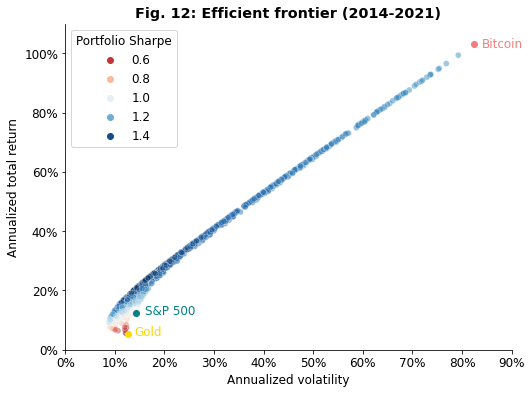

In [474]:
# Run 1000 random portfolio samples to build risk-return scatter (estimated efficient frontier)
risk_return = {}
risk_weights = {}

np.random.seed(1)

for i in np.random.uniform(0, 0.99, 1000):
    w_sp500 = round(i, 4)
    w_btc = np.random.randint(100-w_sp500*100) / 100
    w_gold = 1 - w_sp500 - w_btc

    port_vola = ( (w_sp500**2)*(sp500_std_ann**2) + (w_btc**2)*(btc_std_ann**2) + (w_gold**2)*(gold_std_ann**2) 
            + (2*w_sp500*w_btc*sp500_std_ann*btc_std_ann*corr_sp500_btc) 
            + (2*w_sp500*w_gold*sp500_std_ann*gold_std_ann*corr_sp500_gold)
            + (2*w_btc*w_gold*btc_std_ann*gold_std_ann*corr_btc_gold) ) ** (1/2)
            
    port_return = w_sp500*sp500_perf_ann + w_btc*btc_perf_ann + w_gold*gold_perf_ann

    risk_return[port_vola] = port_return
    risk_weights[port_vola] = w_sp500, w_gold, w_btc

risk_return_df = pd.DataFrame(list(risk_return.items()),columns = ['Ptf volatility','Ptf return']) 
risk_weights_df = pd.DataFrame(list(risk_weights.items()),columns = ['Ptf volatility','Asset class weights']) 
risk_return_df['Ptf Sharpe'] = risk_return_df['Ptf return'] / risk_return_df['Ptf volatility']
portfolio_df = risk_return_df.merge(risk_weights_df)   


fig, ax = plt.subplots(figsize=(8,6))
plt.title('Fig. 12: Efficient frontier (2014-2021)',fontweight='bold')

sns.scatterplot(portfolio_df['Ptf volatility'],portfolio_df['Ptf return'],hue=portfolio_df['Ptf Sharpe'], palette='RdBu', alpha = 0.5)
ax.scatter(sp500_std_ann, sp500_perf_ann, color='teal')
ax.scatter(btc_std_ann, btc_perf_ann, color='lightcoral')
ax.scatter(gold_std_ann, gold_perf_ann, color='gold')
ax.set_xlabel('Annualized volatility')
ax.set_ylabel('Annualized total return')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax.set_ylim([0,1.1])
ax.set_xlim([0,0.9])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper left',title='Portfolio Sharpe')
ax.annotate('S&P 500', (0.16, 0.12), color='teal')
ax.annotate('Bitcoin', (0.84, 1.02), color='lightcoral')
ax.annotate('Gold', (0.14, 0.05), color='gold')

plt.show()

> Figure 12 shows the output of 1000 randomly-sampled portfolio allocations. It visualizes the efficient frontier between the three asset classes (and highlights once more the outsized returns and volatility of Bitcoin).  

In [475]:
#Approximate the min vola and max Sharpe ratio portfolios (from the 1000 random samples above)
min_vola = portfolio_df['Ptf volatility'].min()
min_vola_return = portfolio_df['Ptf return'][portfolio_df['Ptf volatility'] == min_vola]
min_vola_SR = portfolio_df['Ptf Sharpe'][portfolio_df['Ptf volatility'] == min_vola]
min_vola_wghts = portfolio_df['Asset class weights'][portfolio_df['Ptf volatility'] == min_vola]

max_SR = portfolio_df['Ptf Sharpe'].max()
max_SR_vola = portfolio_df['Ptf volatility'][portfolio_df['Ptf Sharpe'] == max_SR]
max_SR_return = portfolio_df['Ptf return'][portfolio_df['Ptf Sharpe'] == max_SR]
max_SR_wghts = portfolio_df['Asset class weights'][portfolio_df['Ptf Sharpe'] == max_SR]

#Summary table
Opt_ptfs1 = {'Equity weight (in %)': [round(min_vola_wghts.reset_index()['Asset class weights'][0][0]*100,0), round(max_SR_wghts.reset_index()['Asset class weights'][0][0]*100,0)], 
            'Gold weight (in %)': [round(min_vola_wghts.reset_index()['Asset class weights'][0][1]*100,0), round(max_SR_wghts.reset_index()['Asset class weights'][0][1]*100,0)],
            'Bitcoin weight (in %)': [round(min_vola_wghts.reset_index()['Asset class weights'][0][2]*100,0), round(max_SR_wghts.reset_index()['Asset class weights'][0][2]*100,0)],
            'Annual ptf return (in %)': [round(min_vola_return.iloc[0]*100,2), round(max_SR_return.iloc[0]*100,2)],
            'Annual ptf volatility (in %)': [round(min_vola*100,2), round(max_SR_vola.iloc[0]*100,2)], 
            'Ptf Sharpe ratio': [round(min_vola_SR.iloc[0],2), round(max_SR,2)] }

Opt_ptfs1_df = pd.DataFrame(Opt_ptfs1).transpose()
Opt_ptfs1_df.columns = ['Min volatility ptf (random sampling)', 'Max Sharpe ptf (random sampling)']

print('\033[1m' + 'Fig. 13: Minimum volatility and maximum Sharpe ratio portfolios (approximated by random sampling)')
display(Opt_ptfs1_df)

Fig. 13: Minimum volatility and maximum Sharpe ratio portfolios (approximated by random sampling)


,Min volatility ptf (random sampling),Max Sharpe ptf (random sampling)
Equity weight (in %),51.00,46.00
Gold weight (in %),49.00,41.00
Bitcoin weight (in %),0.00,13.00
Annual ptf return (in %),9.06,21.43
Annual ptf volatility (in %),8.83,14.72
Ptf Sharpe ratio,1.03,1.46


> From the 1000 sample portfolios we identified the minimum volatility and maximum Sharpe ratio portfolios (allocation weights are rounded to full percentages). Figure 13 shows the details. 

> In Figure 14 below we add those to the efficient frontier chart (the right chart just "zooms into" the most relevant area). Finally, to get a precise result, we will use PyPortfolioOpt for optimization of the minimum volatility and maximum Sharpe ratio portfolios.

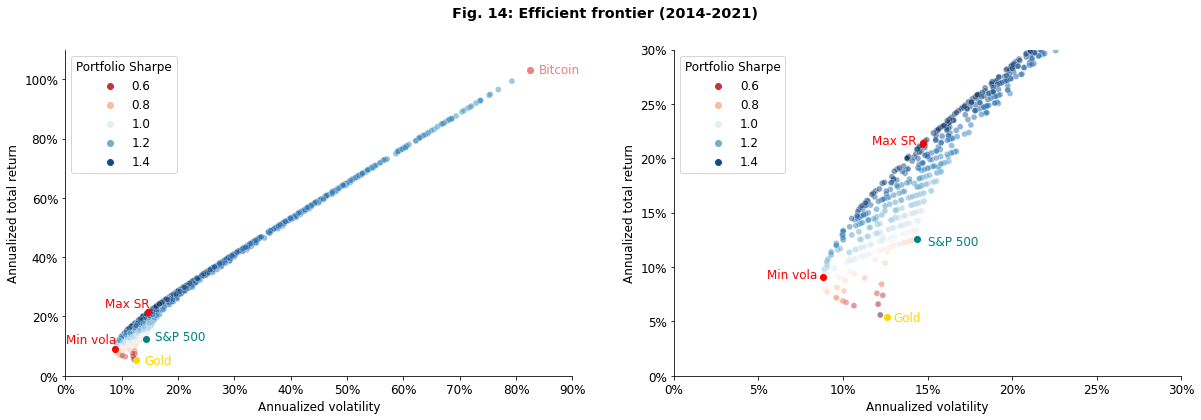

In [476]:
#Add min vola and max Sharpe portfolios to efficinet frontier chart (and "zoom in")
fig, ax = plt.subplots(1,2,figsize=(20,6))
plt.suptitle('Fig. 14: Efficient frontier (2014-2021)',fontweight='bold')

sns.scatterplot(portfolio_df['Ptf volatility'],portfolio_df['Ptf return'],ax=ax[0],hue=portfolio_df['Ptf Sharpe'], palette='RdBu', alpha = 0.5)
ax[0].scatter(sp500_std_ann, sp500_perf_ann, color='teal')
ax[0].scatter(btc_std_ann, btc_perf_ann, color='lightcoral')
ax[0].scatter(gold_std_ann, gold_perf_ann, color='gold')
ax[0].set_xlabel('Annualized volatility')
ax[0].set_ylabel('Annualized total return')
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax[0].set_ylim([0,1.1])
ax[0].set_xlim([0,0.9])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].legend(loc='upper left',title='Portfolio Sharpe')
ax[0].annotate('S&P 500', (0.16, 0.12), color='teal')
ax[0].annotate('Bitcoin', (0.84, 1.02), color='lightcoral')
ax[0].annotate('Gold', (0.14, 0.04), color='gold')

ax[0].scatter(min_vola, min_vola_return, color='red')
ax[0].scatter(max_SR_vola, max_SR_return, color='red')
ax[0].annotate('Min vola', (0.001, 0.11), color='red')
ax[0].annotate('Max SR', (0.07, 0.23), color='red')


sns.scatterplot(portfolio_df['Ptf volatility'],portfolio_df['Ptf return'],ax=ax[1],hue=portfolio_df['Ptf Sharpe'], palette='RdBu', alpha = 0.5)
ax[1].scatter(sp500_std_ann, sp500_perf_ann, color='teal')
ax[1].scatter(btc_std_ann, btc_perf_ann, color='lightcoral')
ax[1].scatter(gold_std_ann, gold_perf_ann, color='gold')
ax[1].set_xlabel('Annualized volatility')
ax[1].set_ylabel('Annualized total return')
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals=0))
ax[1].set_ylim([0,0.3])
ax[1].set_xlim([0,0.3])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].legend(loc='upper left',title='Portfolio Sharpe')
ax[1].annotate('S&P 500', (0.15, 0.12), color='teal')
ax[1].annotate('Gold', (0.13, 0.05), color='gold')

ax[1].scatter(min_vola, min_vola_return, color='red')
ax[1].scatter(max_SR_vola, max_SR_return, color='red')
ax[1].annotate('Min vola', (0.055, 0.09), color='red')
ax[1].annotate('Max SR', (0.117, 0.213), color='red')

plt.show()

### 6.3. Portfolio optimization with PyPortfolioOpt

In [477]:
#Install and import PyPortfolioOpt to find optimal portfolio weights
!pip install --upgrade PyPortfolioOpt --upgrade cvxpy --upgrade cvxopt --no-deps

from pypfopt import EfficientFrontier
import cvxpy as cp

  Using cached PyPortfolioOpt-1.5.1-py3-none-any.whl (61 kB)
  Using cached cvxpy-1.1.18-cp38-cp38-manylinux_2_24_x86_64.whl (2.7 MB)
  Using cached cvxopt-1.2.7-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)


In [478]:
#Min vola optimization
cov = corr_df.drop('US CPI',axis=1).cov()*12
exp_returns = [sp500_perf_ann, gold_perf_ann, btc_perf_ann]

ef = EfficientFrontier(exp_returns, cov, solver=cp.CVXOPT)

ef.min_volatility()
min_vola_wghts = ef.clean_weights()
min_vola_ptf = ef.portfolio_performance(risk_free_rate=0)

In [479]:
#Max Sharpe optimization
ef = EfficientFrontier(exp_returns, cov)

ef.max_sharpe(risk_free_rate=0)
max_SR_wghts = ef.clean_weights()
max_SR_ptf = ef.portfolio_performance(risk_free_rate=0)

In [480]:
#Min vola optimization with a min. BTC weight of 2%
ef = EfficientFrontier(exp_returns, cov, weight_bounds=(0.02,1))

ef.min_volatility()
min_volaBTC_wghts = ef.clean_weights()
min_volaBTC_ptf = ef.portfolio_performance(risk_free_rate=0)

In [481]:
#Summary table
Opt_ptfs2 = {'Equity weight (in %)': [round(min_vola_wghts['S&P 500']*100,0), round(max_SR_wghts['S&P 500']*100,0), round(min_volaBTC_wghts['S&P 500']*100,0)], 
            'Gold weight (in %)': [round(min_vola_wghts['Gold']*100,0), round(max_SR_wghts['Gold']*100,0), round(min_volaBTC_wghts['Gold']*100,0)],
            'Bitcoin weight (in %)': [round(min_vola_wghts['Bitcoin']*100,0), round(max_SR_wghts['Bitcoin']*100,0), round(min_volaBTC_wghts['Bitcoin']*100,0)],
            'Annual ptf return (in %)': [round(min_vola_ptf[0]*100,2), round(max_SR_ptf[0]*100,2), round(min_volaBTC_ptf[0]*100,2)],
            'Annual ptf volatility (in %)': [round(min_vola_ptf[1]*100,2), round(max_SR_ptf[1]*100,2), round(min_volaBTC_ptf[1]*100,2)], 
            'Ptf Sharpe ratio': [round(min_vola_ptf[2],2), round(max_SR_ptf[2],2), round(min_volaBTC_ptf[2],2)] }

Opt_ptfs2_df = pd.DataFrame(Opt_ptfs2).transpose()
Opt_ptfs2_df.columns = ['Min volatility ptf (opt.)', 'Max Sharpe ptf (opt.)', 'Min Volatility with 2% BTC allocation (opt.)']

print('\033[1m' + 'Fig. 15: Minimum volatility and maximum Sharpe ratio portfolios (optimized)')
display(Opt_ptfs2_df)

Fig. 15: Minimum volatility and maximum Sharpe ratio portfolios (optimized)


,Min volatility ptf (opt.),Max Sharpe ptf (opt.),Min Volatility with 2% BTC allocation (opt.)
Equity weight (in %),44.00,44.00,42.00
Gold weight (in %),56.00,43.00,56.00
Bitcoin weight (in %),0.00,13.00,2.00
Annual ptf return (in %),8.58,21.19,10.35
Annual ptf volatility (in %),8.73,14.52,9.03
Ptf Sharpe ratio,0.98,1.46,1.15


> Using the historic annual returns and the (annualized) variance/covariance matrix of our three assets (and a risk-free rate of zero) as inputs we can find the optimal portfolio allocations, based on classical mean-variance optimization. Figure 15 summarizes the results (allocation weights are rounded to full percentages again).

> The optimal portfolio weights are relatively close to our earlier approximations. Still, optimization further improved the outcome, in particular for the minimum volatility portfolio, which unsurprisingly still contains no allocation to Bitcoin.

> In order to acknowledge the superior (risk-adjusted) returns Bitcoin has generated so far, an interesting option could be to allocate a small fixed weight (of say 2%) to Bitcoin and minimize portfolio volatility with this additional constraint. The result is shown in the right column of figure 15. The small Bitcoin allocation increases risk, return and Sharpe ratio compared to the strict minimum volatility portfolio. But the increase in volatility (from 8.7% to 9%) is relatively small. So, this small allocation to Bitcoin would have improved the fund's performance significantly, without changing its risk profile meaningfully. It would offer the additional advantage of gaining more hands-on experience with investing in Bitcoin, before potentially re-assessing again.

### 6.4. Illustration of optimal portfolios

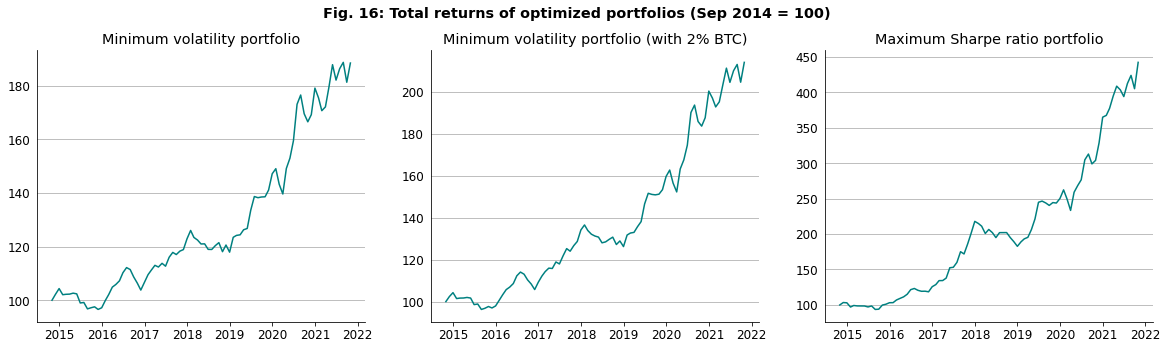

In [482]:
#Illustrate the historic development for three "optimal" portfolios in a line chart
corr_df['Min vola ptf'] = min_vola_wghts['S&P 500']*corr_df['S&P 500'] + min_vola_wghts['Gold']*corr_df['Gold'] + min_vola_wghts['Bitcoin']*corr_df['Bitcoin']
corr_df['Max Sharpe ptf'] = max_SR_wghts['S&P 500']*corr_df['S&P 500'] + max_SR_wghts['Gold']*corr_df['Gold'] + max_SR_wghts['Bitcoin']*corr_df['Bitcoin']
corr_df['Min vola w. BTC ptf'] = min_volaBTC_wghts['S&P 500']*corr_df['S&P 500'] + min_volaBTC_wghts['Gold']*corr_df['Gold'] + min_volaBTC_wghts['Bitcoin']*corr_df['Bitcoin']

corr_df['Min vola ptf index'] = 100.0
corr_df['Max Sharpe ptf index'] = 100.0
corr_df['Min vola w. BTC ptf index'] = 100.0

for i in range(len(corr_df)-1):
    corr_df['Min vola ptf index'][i+1] = corr_df['Min vola ptf index'][i] * (1 + corr_df['Min vola ptf'][i+1])
    corr_df['Max Sharpe ptf index'][i+1] = corr_df['Max Sharpe ptf index'][i] * (1 + corr_df['Max Sharpe ptf'][i+1])
    corr_df['Min vola w. BTC ptf index'][i+1] = corr_df['Min vola w. BTC ptf index'][i] * (1 + corr_df['Min vola w. BTC ptf'][i+1])

    
fig, ax = plt.subplots(1,3, figsize=(20,5))
plt.suptitle('Fig. 16: Total returns of optimized portfolios (Sep 2014 = 100)',fontweight='bold',y=1.0)

ax[0].plot(corr_df.index, corr_df['Min vola ptf index'],color='teal')
ax[0].set_title('Minimum volatility portfolio')
ax[0].grid(axis='y')

ax[1].plot(corr_df.index, corr_df['Min vola w. BTC ptf index'],color='teal')
ax[1].set_title('Minimum volatility portfolio (with 2% BTC)')
ax[1].grid(axis='y')

ax[2].plot(corr_df.index, corr_df['Max Sharpe ptf index'],color='teal')
ax[2].set_title('Maximum Sharpe ratio portfolio')
ax[2].grid(axis='y')

chart_formatter(3)

plt.show()

> Figure 16 shows how these three "optimal" portfolios would have performed since 2014. The minimum volatility portfolio would have almost doubled in value since 2014 (+88%). Adding a fixed 2% allocation to Bitcoin would have increased performance to 114%. The value of the maximum Sharpe ratio portfolio would have more than quadrupled over the period (+342%).

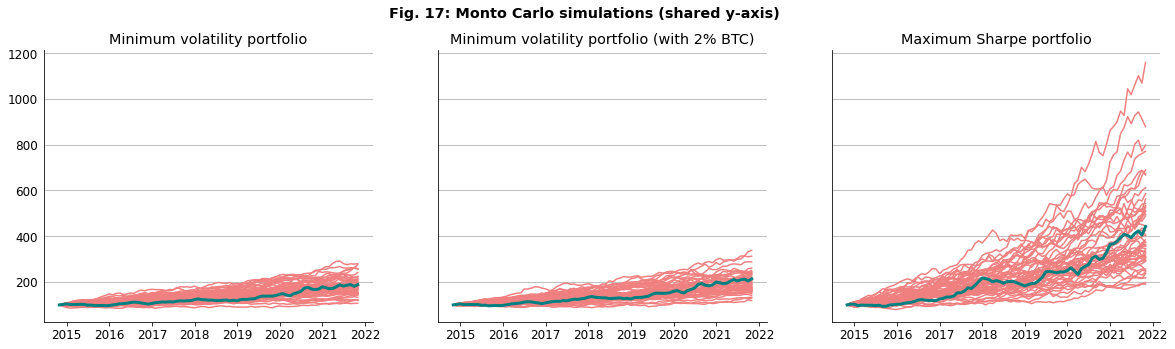

In [483]:
#Add MC simulation based on normal distribution for both portfolios (just 50 runs each for illustration)
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
plt.suptitle('Fig. 17: Monto Carlo simulations (shared y-axis)',fontweight='bold',y=1.0)

ax[0].set_title('Minimum volatility portfolio')
ax[0].grid(axis='y')

ax[1].set_title('Minimum volatility portfolio (with 2% BTC)')
ax[1].grid(axis='y')

ax[2].set_title('Maximum Sharpe portfolio')
ax[2].grid(axis='y')

chart_formatter(3)

np.random.seed(1)

for i in range(50):

    s = np.random.normal((1+min_vola_ptf[0])**(1/12)-1, min_vola_ptf[1] / (12**0.5),85)

    corr_df['random'] = s
    corr_df['random index'] = 100.0

    for j in range(len(corr_df)-1):
        corr_df['random index'][j+1] = corr_df['random index'][j] * (1 + corr_df['random'][j+1])

    ax[0].plot(corr_df.index, corr_df['random index'],color='lightcoral')

    
for i in range(50):

    s = np.random.normal((1+min_volaBTC_ptf[0])**(1/12)-1, min_volaBTC_ptf[1] / (12**0.5),85)

    corr_df['random'] = s
    corr_df['random index'] = 100.0

    for j in range(len(corr_df)-1):
        corr_df['random index'][j+1] = corr_df['random index'][j] * (1 + corr_df['random'][j+1])

    ax[1].plot(corr_df.index, corr_df['random index'],color='lightcoral')  


for i in range(50):

    s = np.random.normal((1+max_SR_ptf[0])**(1/12)-1, max_SR_ptf[1] / (12**0.5),85)

    corr_df['random'] = s
    corr_df['random index'] = 100.0

    for j in range(len(corr_df)-1):
        corr_df['random index'][j+1] = corr_df['random index'][j] * (1 + corr_df['random'][j+1])

    ax[2].plot(corr_df.index, corr_df['random index'],color='lightcoral') 

    
ax[0].plot(corr_df.index, corr_df['Min vola ptf index'],color='teal',linewidth=3)
ax[1].plot(corr_df.index, corr_df['Min vola w. BTC ptf index'],color='teal',linewidth=3)
ax[2].plot(corr_df.index, corr_df['Max Sharpe ptf index'],color='teal',linewidth=3)

plt.show()

> To illustrate the uncertainty of outcomes, figure 17 adds a simple Monte Carlo simulation of returns around the historically realized portfolio returns (with 50 runs for each portfolio). This is assuming monthly returns to be normally distributed, which admittedly is a stretch based on our prior analysis. Still, it helps illustrate the impact that a meaningful inclusion of Bitcoin in a portfolio has on risk. The "cone" of possible outcomes for the maximum Sharpe ratio portfolio (with its 13% Bitcoin allocation) is pretty wide (ranging roughly from +100% to +1100% over the period). 

> Scenarios for the "middle ground" portfolio, minimizing volatility under a 2% Bitcoin allocation constraint, are reasonably close to the minimum volatility portfolio (ranging roughly from 0% to +200%), corroborating our view that the risk profile is not materially changed by this small Bitcoin allocation.

## 7. Summary of main findings

Before we conclude with our recommendation for the fund's allocation, let's summarize the main findings of our analysis:

**Question 1: How does the performance of Bitcoin (i.e. risk and returns) compare to the S&P 500 and gold?**<br>
Bitcoin strongly outperformed both asset classes since 2014, delivering average annual returns of more than 100%. This outperformance came at the expense of significantly higher risk (across a range of measures like volatility, Value-at-Risk, drawdown or daily trading range). Still, risk-adjusted returns of Bitcoin (with a Sharpe ratio of 1.3) exceeded those of gold (0.4) or US stocks (0.9).

**Question 2: How does the inclusion of Bitcoin change a portfolio's characteristics and can it help improve a portfolio's performance?**<br>
Given the above it is not surprising that the inclusion of Bitcoin would have increased a portfolio's risk and return significantly. Bitcoin's correlation to US equities has been mildly positive since 2014 (with a correlation coefficient of 0.3), thus offering limited diversification benefits. We showed that in the past Bitcoin could help increase portfolio returns, but only at the expense of higher risk.

**Question 3: Could Bitcoin be used as a hedge against inflation?**<br>
No. There has been no consistent relationship between monthly changes in the general US consumer price level and the price of Bitcoin. On the positive side that means Bitcoin does not consistently suffer from rising (or falling) inflation. But it also does not consistently gain in an environment of high inflation, thus not offering good hedging properties. It's worth noting that inflation has been relatively low throughout the observation period. So, how Bitcoin will behave under structurally high inflation remains to be seen.

**Question 4: In the light of our fund's goal to minimize risk: What is the minimum volatility portfolio, consisting of these three asset classes? And for comparison: Which portfolio would maximize risk-adjusted returns?**<br>
Historically, the portfolio minimizing volatility consisted of 44% US equities, 56% gold and no Bitcoin. This portfolio achieved a volatility of 8.7% p.a. since 2014 and a Sharpe ratio of close to 1.0. The maximum Sharpe ratio of 1.46 would have been achieved with an allocation of 44% to US equities, 43% to gold and 13% to Bitcoin. This portfolio's volatility was 14.5% p.a.

## 8. Recommendations & next steps
The motivating question of this report was to recommend an allocation to Bitcoin as part of a 3-asset portfolio. Given the very high historic volatility of Bitcoin and its limited diversification value vs. equities, **there is no place for Bitcoin, when the goal is to strictly minimize the fund's volatility (see question 4 above)**.

But to acknowledge the superior returns and high Sharpe ratio that Bitcoin has shown so far, **we still recommend to consider a small fixed allocation of 2% to Bitcoin**, alongside 42% in US stocks and 56% in gold. Since 2014 such an allocation would have increased volatility relatively little compared to the minimum volatility portfolio (from 8.7% to 9%), while significantly improving returns (from 8.6% to 10.4%) and the Sharpe ratio (from 1 to 1.15). It has the additional benefit of offering a way to gain further hands-on experience with investing in Bitcoin, while conducting further analysis.

Given that our analysis is entirely backward-looking **we strongly suggest to complement it with more forward-looking research**. The results of the past 7 years cannot simply be extrapolated, especially considering the "youth" of Bitcoin as a mainstream investment and its gain in popularity over this period. Whether returns of 100% p.a. can be repeated seems highly uncertain, to say the least. Important areas for further research include 1) the fundamental case for Bitcoin as a viable asset class (i.e. (why) will it survive in the long run?), 2) valuation approaches to Bitcoin to estimate long-term forward-looking returns as part of a comprehensive set of capital market assumptions and 3) implementation challenges of Bitcoin (e.g. its very high intraday volatility; costs and benefits of direct vs. indirect investments).

**Thanks for reading :-)!**

## 9. References

*Martin, R. A., (2021). PyPortfolioOpt: portfolio optimization in Python. Journal of Open Source Software, 6(61), 3066, https://doi.org/10.21105/joss.03066*

*CPI data from the U.S. Bureau of Labor Statistics. Publicly available information*